# 0. Imports

In [4]:
from pipeline.config import CUDA_DEVICE, DEBUG, SCANS, PROJ_DIR, PHASE_DATAVER_DIR, RESULT_DIR, data_version, PD_training_app, PD_epochs, PD_network_name, PD_model_name, PD_batch_size, PD_optimizer, PD_num_workers, ID_training_app, ID_epochs, ID_network_name, ID_model_name, ID_batch_size, ID_optimizer, ID_num_workers
from pipeline.proj import load_projection_mat, reformat_sinogram, interpolate_projections, pad_and_reshape, divide_sinogram
from pipeline.aggregate_prj import aggregate_saved_projections
# from .aggregate_ct import aggregate_saved_volumes
from pipeline.launcher import run_app
from pipeline.apply_model import apply_model_to_projections, load_model
# from .infer3d import inference_3d
from pipeline.utils import ensure_dir
import torch
import scipy.io
import os
import logging
import matplotlib.pyplot as plt

# Show info messages if DEBUG mode is enabled
if DEBUG:
    logging.basicConfig(level=logging.INFO)
    logging.info("DEBUG mode is enabled. Detailed logs will be shown.")
else:
    logging.basicConfig(level=logging.WARNING)
    logging.warning("DEBUG mode is disabled. Only warnings and errors will be shown.")

# TODO run FDK via: FFrecon_reconFDK(input_mat, output_mat); in file "FFrecon_fullFDK.m"
# TODO add DEBUG mode that prints out helpful info like shapes, etc. (and be sure to set logging level so 'info' shows up too)
# TODO add some kind of logging for the hyperparameters used in the each run
# TODO go through the training code and make sure it is consistent with new pipeline
# TODO save everything as numpy arrays instead of torch tensors, and then convert to torch tensors when needed
# TODO add more options for training like learning rate, etc.

INFO:root:DEBUG mode is enabled. Detailed logs will be shown.


# 1. Data Preparation: projection interpolation

In [18]:
for patient, scan, scan_type, sample in SCANS:
    # Load the projection data from the matlab files
    odd_index, angles, prj = load_projection_mat(patient, scan, scan_type)

    # Log shapes of loaded data
    logging.info(f'Processing patient {patient}, scan {scan}, type {scan_type}, sample {sample}')
    logging.info(f'Loaded odd_index shape: {odd_index.shape}')
    logging.info(f'Loaded angles shape: {angles.shape}')
    logging.info(f'Loaded projection shape: {prj.shape}')

    # Flip and permute to get it in the right format
    prj_gcbct, angles1 = reformat_sinogram(prj, angles)

    # Log shapes after reformatting
    logging.info(f'Reformatted projection shape: {prj_gcbct.shape}')

    # Simulate ngCBCT projections
    prj_ngcbct_li = interpolate_projections(prj_gcbct, odd_index)

    # Log shapes after interpolation
    logging.info(f'Interpolated ngCBCT projection shape: {prj_ngcbct_li.shape}')

    # Split the projections into two halves so they are good dimensions for the CNN
    combined_gcbct = divide_sinogram(pad_and_reshape(prj_gcbct), v_dim=512 if scan_type == "HF" else 256)
    combined_ngcbct = divide_sinogram(pad_and_reshape(prj_ngcbct_li), v_dim=512 if scan_type == "HF" else 256)

    # Log shapes after dividing sinograms
    logging.info(f'Combined gCBCT shape: {combined_gcbct.shape}')
    logging.info(f'Combined ngCBCT shape: {combined_ngcbct.shape}')

    # Ensure the output directories exist
    g_dir = os.path.join(PROJ_DIR, 'gated')
    ng_dir = os.path.join(PROJ_DIR, 'ng')
    ensure_dir(g_dir)
    ensure_dir(ng_dir)

    logging.info(f'Saving projections...')
    
    # Save the projections
    torch.save(combined_gcbct, os.path.join(g_dir, f'{scan_type}_p{patient}_{scan}_{sample}.pt')) # e.g., HF_p01_01_TRAIN.pt
    torch.save(combined_ngcbct, os.path.join(ng_dir, f'{scan_type}_p{patient}_{scan}_{sample}.pt'))

    logging.info(f'Done with patient {patient}, scan {scan}, type {scan_type}, sample {sample}\n')

logging.info("All projections saved successfully.")
logging.info("Gated projections saved in: %s", g_dir)
logging.info("Non-gated projections saved in: %s", ng_dir)

# Free up memory
del odd_index, angles, prj, prj_gcbct, angles1, prj_ngcbct_li, combined_gcbct, combined_ngcbct

INFO:root:Processing patient 01, scan 01, type HF, sample TRAIN
INFO:root:Loaded odd_index shape: (440,)
INFO:root:Loaded angles shape: torch.Size([908])
INFO:root:Loaded projection shape: torch.Size([510, 382, 908])
INFO:root:Reformatted projection shape: torch.Size([908, 382, 510])
INFO:root:Interpolated ngCBCT projection shape: torch.Size([908, 382, 510])
INFO:root:Combined gCBCT shape: torch.Size([764, 1, 512, 512])
INFO:root:Combined ngCBCT shape: torch.Size([764, 1, 512, 512])
INFO:root:Saving projections...
INFO:root:Done with patient 01, scan 01, type HF, sample TRAIN

INFO:root:Processing patient 02, scan 01, type FF, sample TRAIN
INFO:root:Loaded odd_index shape: (259,)
INFO:root:Loaded angles shape: torch.Size([496])
INFO:root:Loaded projection shape: torch.Size([510, 382, 496])
INFO:root:Reformatted projection shape: torch.Size([496, 382, 510])
INFO:root:Interpolated ngCBCT projection shape: torch.Size([496, 382, 510])
INFO:root:Combined gCBCT shape: torch.Size([764, 1, 256

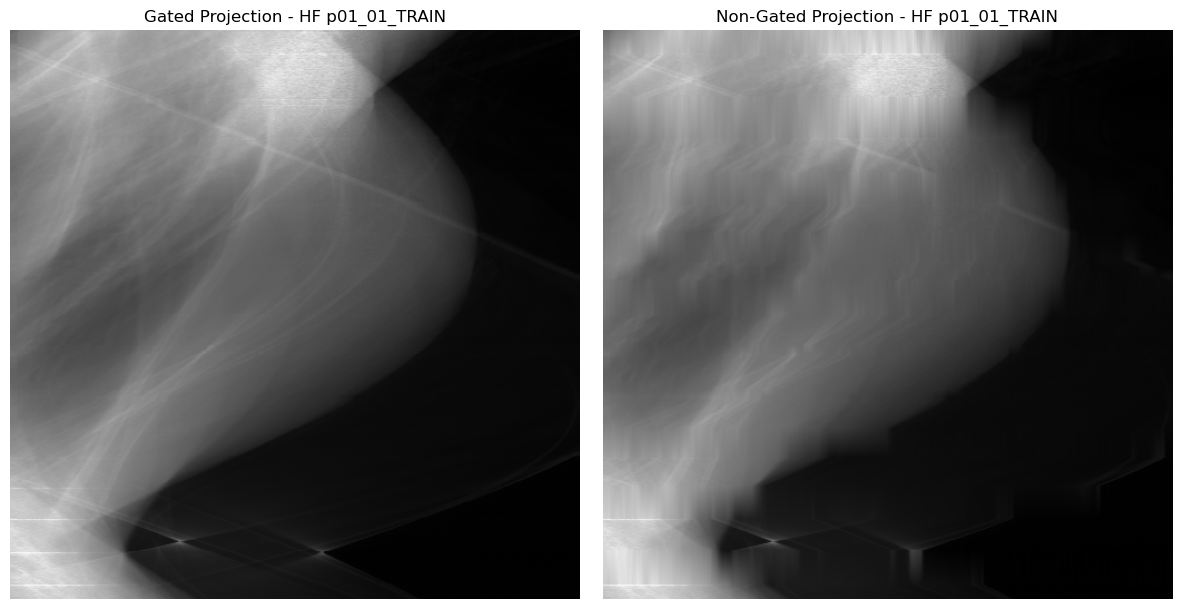

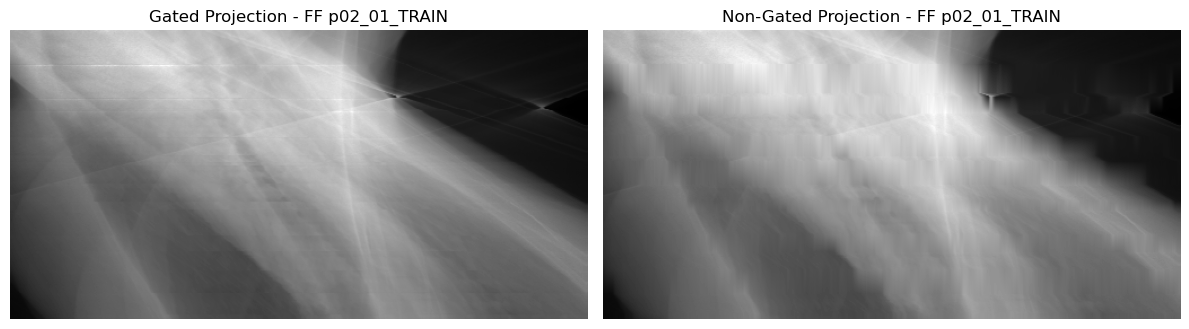

In [ ]:
if DEBUG:
    # Pick the first HF scan and first FF scan
    for patient, scan, scan_type, sample in SCANS:
        if scan_type == "HF":
            hf_scan = (patient, scan, scan_type, sample)
            break
    for patient, scan, scan_type, sample in SCANS:
        if scan_type == "FF":
            ff_scan = (patient, scan, scan_type, sample)
            break

    # Display the first HF scan
    # Show the gated and nonstop-gated on subplots
    hf_patient, hf_scan_num, hf_scan_type, hf_sample = hf_scan
    hf_gated_prj = torch.load(os.path.join(g_dir, f'{hf_scan_type}_p{hf_patient}_{hf_scan_num}_{hf_sample}.pt'))
    hf_ng_prj = torch.load(os.path.join(ng_dir, f'{hf_scan_type}_p{hf_patient}_{hf_scan_num}_{hf_sample}.pt'))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(hf_gated_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
    plt.title(f'Gated Projection - {hf_scan_type} p{hf_patient}_{hf_scan_num}_{hf_sample}')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(hf_ng_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
    plt.title(f'Nonstop-Gated Projection - {hf_scan_type} p{hf_patient}_{hf_scan_num}_{hf_sample}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Repeat for FF scan
    ff_patient, ff_scan_num, ff_scan_type, ff_sample = ff_scan
    ff_gated_prj = torch.load(os.path.join(g_dir, f'{ff_scan_type}_p{ff_patient}_{ff_scan_num}_{ff_sample}.pt'))
    ff_ng_prj = torch.load(os.path.join(ng_dir, f'{ff_scan_type}_p{ff_patient}_{ff_scan_num}_{ff_sample}.pt'))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(ff_gated_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
    plt.title(f'Gated Projection - {ff_scan_type} p{ff_patient}_{ff_scan_num}_{ff_sample}')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(ff_ng_prj[0, 0, :, :].cpu().numpy(), cmap='gray')
    plt.title(f'Nonstop-Gated Projection - {ff_scan_type} p{ff_patient}_{ff_scan_num}_{ff_sample}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Free up memory
    del hf_gated_prj, hf_ng_prj, ff_gated_prj, ff_ng_prj

# 2. Aggregate projections for train/val/test

In [ ]:
# Directory for aggregated data saving
proj_agg_dir = os.path.join(PHASE_DATAVER_DIR, "agg")
ensure_dir(proj_agg_dir)

# Aggregate and save projection data sets
for scan_type in ['HF', 'FF']:
    for sample in ['TRAIN', 'VALIDATION', 'TEST']:
        prj_gcbct, prj_ngcbct = aggregate_saved_projections(scan_type, sample)
        torch.save(prj_gcbct, os.path.join(proj_agg_dir, f"PROJ_gated_{scan_type}_{sample}.pt")) # e.g., PROJ_gated_HF_TRAIN.pt
        torch.save(prj_ngcbct, os.path.join(proj_agg_dir, f"PROJ_ng_{scan_type}_{sample}.pt"))

# Free up memory
del prj_gcbct, prj_ngcbct

# 3. Training PD CNN

In [ ]:
run_app(PD_training_app, [f'--epoch={PD_epochs}', f'--network={PD_network_name}', f'--model_name={PD_model_name}', f'--data_ver={data_version}', f'--optimizer={PD_optimizer}', '--shuffle=True', f'--DEBUG={DEBUG}', f'--batch_size={PD_batch_size}'], f'--num_workers={PD_num_workers}')

# 4. Apply PD model to all nonstop-gated sinograms

In [ ]:
# Load the trained PD model onto the GPU
PD_model = load_model(PD_network_name, PD_model_name, device=torch.device(CUDA_DEVICE))

for patient, scan, scan_type, sample in SCANS:
    # Get the matlab dicts for the ground truth and CNN projections
    g_mat, cnn_mat = apply_model_to_projections(patient, scan, scan_type, sample, PD_model)

    # Save the ground truth and CNN projections
    scipy.io.savemat(os.path.join(RESULT_DIR, f'PROJ_gated_{scan_type}_p{patient}_{scan}_{sample}.mat'), g_mat) # e.g., PROJ_gated_HF_p01_01_TRAIN.mat
    scipy.io.savemat(os.path.join(RESULT_DIR, f'PROJ_ng_{scan_type}_p{patient}_{scan}_{sample}.mat'), cnn_mat)

# Free up memory
del PD_model, g_mat, cnn_mat

# 5. TODO: FDK

In [ ]:
# TODO

# 6. Aggregate CT volumes for train/val/test

In [ ]:
# Directory for aggregated data saving
vol_agg_dir = os.path.join(DATA_DIR, "agg", "volumes")
ensure_dir(vol_agg_dir)

# Aggregate and save volume data sets
for scan_type in ['HF', 'FF']:
    for sample in ['train', 'validation', 'test']:
        vol_gcbct, vol_ngcbct = aggregate_saved_volumes(scan_type, sample)
        torch.save(vol_gcbct, os.path.join(vol_agg_dir, f"{scan_type}_{sample}_gated.pt"))
        torch.save(vol_ngcbct, os.path.join(vol_agg_dir, f"{scan_type}_{sample}_ng.pt"))

# Free up memory
del vol_gcbct, vol_ngcbct

# 7. Train ID CNN

In [ ]:
# TODO

# 8. Inference on test scans for full 3D

In [ ]:
vol = inference_3d(patient_id, scan_id, 'HF', data_version, model_name, 'tumor_location_panc.pt')